# Sovereign Default Model (Arellano AER 2008)

This notebook accompanies the paper "Benchmarking Machine Learning Software and Hardware for Quantitative Economics" and shows how to solve the sovereign default model of Arellano (AER 2008) using TensorFlow. Below you will find a short summary of the model. For a more detailed desciption, see the main text or https://lectures.quantecon.org/py/arellano.html.

## Model Description
A benevolent government chooses a consumption plan $\{c_t\}$ and government asset holdings of one-period discount bonds $\{B_{t+1}\}$ to maximize its citizens expected discounted utility
\begin{align}\label{eq:utility}
E_0\sum_{t=0}^\infty\beta^t \frac{c_t^{1-\gamma}}{1-\gamma},
\end{align}
where $\beta\in(0,1)$ is the time preference parameter and $\gamma>0$ the relative risk aversion parameter.
In addition, households receive a stochastic stream of tradable good $\{y_t\}$.


At each period, the government can choose to default on its obligation or to repay its debt.
If the government decides to default on its obligation, it is immediately excluded from international financial markets and households consume output $y_t^{def}$, which is lower during financial autarky
\begin{equation}
c_t = y^{def}_t \equiv  \left\{\begin{array}{cc} y_t & \text{ if }  y_t < \hat{y}\\ \hat{y} & \text{ if }  y_t \geq \hat{y} \end{array}\right.,
\end{equation}
for some exogenous threshold $\hat{y}$.
If the government decides to pay its debt, it can access international financial markets to buy one-period bonds $B_{t+1}$ at a competitive endogenous price $q(B_{t+1},y_t)$. The resource constraint is given by

\begin{equation*}
c_t = y_t + B_t - q(B_{t+1},y_t) B_{t+1}.
\end{equation*}

Lenders are risk-neutral and lend at the constant rate $r>0$. The bond price then given by
\begin{equation*}
q(B_{t+1},y_t)= \frac{1- \delta(B_{t+1},y_t)}{1+r},
\end{equation*}
where $\delta(B_{t+1},y_t)$ is the endogenous probability of default.

Denoting the government's value function by $\nu^o(B,y)$, we can write this problem recursively as
\begin{equation*}
\nu^o(B,y) = \max_{\{c,d\}}\left\{\nu^c(B,y),\nu^d(y)\right\},
\end{equation*}
where
\begin{align*}
\nu^d(y) &= u(y^{def}) + \beta\left[\theta\mathbb{E}\nu^o(0,y') + (1-\theta)\mathbb{E}\nu^d(y')\right],\\
\nu^c(B,y)& = \max_{B'}\left\{u(y - q(B',y)B' + B) + \beta\mathbb{E}\nu^o(B',y')\right\}.
\end{align*}
The parameter $\theta$ represents the probability of the government regaining access to international credit markets. Finally, the probability of default is given by

\begin{equation}
\delta(B',y) = \mathbb{E}\left[\nu^d(y') > \nu^c(B', y')\right]
\end{equation}

In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Plotting preferences
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# grid for log endowment
logy_grid = np.loadtxt('./Sovereign_Default/logy_grid.txt', dtype=np.float32)

# Transition matrix, computed with Tauchen's method
Py = np.loadtxt('./Sovereign_Default/P.txt', dtype=np.float32)

# Grid size for bond holdings
nB = 1151

# Grid size for endowment
ny = len(logy_grid)

# Model parameters
β = .953
γ = 2.
r = 0.017
θ = 0.282

repeats = 500 # Number of repeations 
nB = 151 # Grid size for bond holdings

MAX_ITER = 10000  # Maximum number of iterations
tol = 1e-4  # Tolerance for value iteration

Here we define the computation graph. By default, TensorFlow executes in graph mode, so
    none of these intermediary operations are executed in this block. This eliminates overhead.

In [3]:
# Grid for bond holdings
Bgrid = tf.linspace(-.45, .45, nB)
ygrid = tf.exp(logy_grid)

# Initialize value functions and bond price
Vd = tf.Variable(tf.zeros([ny, 1]))   # Value function when if sov. defaults
Vc = tf.Variable(tf.zeros((ny, nB)))  # Value function when if sov. does not default
V = tf.Variable(tf.zeros((ny, nB)))   # Value function
Q = tf.Variable(tf.ones((ny, nB)) * .95)  # Bond price

# Reshape grids to facilitate broacasting operations. Dimensions are:
# 0: endowment dimension
# 1: Bondholdings dimension
# 2: Bondholdings in the next period dimension
y = tf.reshape(ygrid, [-1, 1, 1])
B = tf.reshape(Bgrid, [1, -1, 1])
Bnext = tf.reshape(Bgrid, [1, 1, -1])

zero_ind = nB // 2  # Index of zero bond holdings

# Utility function
def u(c):
    return c**(1 - γ) / (1 - γ)

# Endowment in autarky
ymean = tf.reduce_mean(ygrid)
def_y = tf.minimum(0.9776, ygrid)

# Expectations
EV = Py @ V
EVd = Py @ Vd
EVc = Py @ Vc

# bellman target for Vd
Vd_target = u(def_y) + β * (θ * EVc[:, zero_ind] + (1 - θ) * EVd[:, 0])
Vd_target = tf.reshape(Vd_target, [-1, 1])

# bond price next period
Qnext = tf.expand_dims(Q, axis=1)

# Bellman target for Vc
c = tf.nn.relu(y - Qnext * Bnext + B)
EV = tf.expand_dims(EV, axis=1)
m = u(c) + β * EV
Vc_target = tf.reduce_max(m, axis=2)

# Update bond price--- risk neutral pricing
default_states = tf.cast(Vd > Vc, tf.float32)
default_prob = Py @ default_states
Q_target = (1 - default_prob) / (1 + r)

# Value function
V_target = tf.maximum(Vc, Vd)

# Create operations to update all tensors
update_V = V.assign(V_target)
update_Vc = Vc.assign(Vc_target)
update_Vd = Vd.assign(Vd_target)
update_Q = Q.assign(Q_target)

This is the block where we execute the operations defined above. Before this execution, we must first 
launch a session. This is what ensures that the operations will be executed using C++ and CUDA kernels as opposed
to being executed by the Python interpreter.

In [7]:
# We instruct TensorFlow to use the XLA compiler (optional).
config = tf.ConfigProto()
config.graph_options.optimizer_options.global_jit_level = 1

# Now we launch the session and initialize global variables
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

# Now iterate until convergence. Iterating means executing the "update" operations
# defined in the block above. We say that the procedure "converged" if the difference between V
# and it's previous value is less than tol. Finally we monitor that difference by printing it
# every 50 iterations
V_ = sess.run(V)  # V_ is the numerical value of the symbolic tensor V

for counter in range(MAX_ITER):
    sess.run(update_Vd)
    sess.run(update_Vc)
    sess.run(update_Q)
    sess.run(update_V)
    
    if counter % 50 == 0 and counter > 10:
        V_new_ = sess.run(V)
        dist = np.abs(V_ - V_new_).max()
        V_ = V_new_
        print("Max error = " + str(dist))
        
        if dist < tol:
            print('\n\nConverged!')
            break


Max error = 21.783352
Max error = 1.7164879
Max error = 0.1536808
Max error = 0.013845444
Max error = 0.0012550354
Max error = 0.000120162964
Max error = 1.5258789e-05


Converged!


Text(0.5, 0.92, 'Probability of Default')

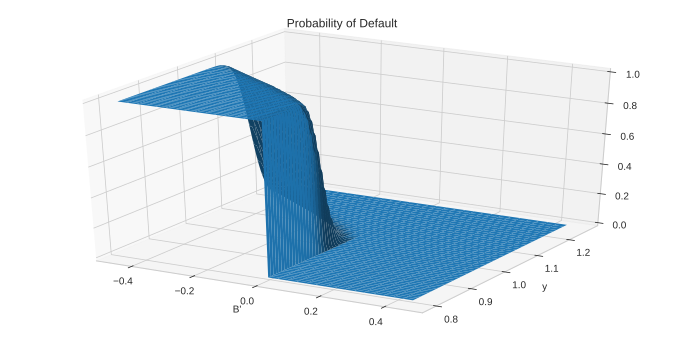

In [8]:
# Create some plots
plt.style.use('seaborn-whitegrid')
X, Y, Z = sess.run([Bgrid, ygrid, default_prob])

X, Y = np.meshgrid(X, Y)
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, rstride=5, cstride=5, linewidth=0)
plt.xlabel("B'")
plt.ylabel('y')
plt.title('Probability of Default')
# plt.grid(b=None)

